In [26]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from rich.console import Console
from rich.table import Table

Nodo y Arco Consistencia


In [2]:
# Nodo Consistencia
domains = {
    'x1': [i for i in range(0,16)],
    'x2': [i for i in range(0,11)],
    'x3': [i for i in range(0,26)],
    'x4': [i for i in range(0,5)],
    'x5': [i for i in range(0,31)],
}

In [3]:
# Restricciones
constraints = {

    ('x1', 'x2'): lambda x1, x2:  170*x1 <= 3800-310*x2,
    ('x2', 'x1'): lambda x2, x1:  3800-310*x2 >= 170*x1,

    ('x3', 'x4'): lambda x3, x4:  60*x3 <= 2800-101*x4,
    ('x4', 'x3'): lambda x4, x3:  2800-101*x4 >= 60*x3,

    ('x3', 'x5'): lambda x3, x5:  60*x3 <= 3500-11*x5,
    ('x5', 'x3'): lambda x5, x3:  3500-11*x5 >= 60*x3,

}

In [4]:
# Implementación de AC3
def revise(x, y):
    revised = False
    x_domain = domains[x]
    y_domain = domains[y]
    all_constraints = [
        constraint for constraint in constraints if constraint[0] == x and constraint[1] == y]
    for x_value in x_domain:
        satisfies = False
        for y_value in y_domain:
            for constraint in all_constraints:
                constraint_func = constraints[constraint]
                if constraint_func(x_value, y_value):
                    satisfies = True
        if not satisfies:
            x_domain.remove(x_value)
            revised = True
    return revised

def ac3(arcs):
    queue = arcs[:]
    while queue:
        (x, y) = queue.pop(0)
        revised = revise(x, y)
        if revised:
            neighbors = [neighbor for neighbor in arcs if neighbor[1] == x]
            queue = queue + neighbors


In [5]:
# Arcos de las restricciones del problema
arcs = [
    ('x1','x2'), ('x2','x1'),
    ('x3','x4'), ('x4','x3'),
    ('x3', 'x5'), ('x5','x3')
]

ac3(arcs)

print("x1: " + str(domains['x1']))
print("x2: " + str(domains['x2']))
print("x3: " + str(domains['x3']))
print("x4: " + str(domains['x4']))
print("x5: " + str(domains['x5']))

x1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
x2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
x4: [0, 1, 2, 3, 4]
x5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [6]:
class Problema:
  def __init__(self, epsilon):
    self.epsilon = epsilon
    self.dimensiones = 5
    self.limites = {
      'x1': (0, 15),
      'x2': (0, 10),
      'x3': (0, 25),
      'x4': (0, 4),
      'x5': (0, 30)
    }

    self.costos = {
      'x1': 170,
      'x2': 310,
      'x3': 60,
      'x4': 101,
      'x5': 11
    }

    self.presMaxTv = 3800
    self.presMaxDyR = 2800
    self.presMaxDyR = 3500

  def check(self, x):
    # Chequeo de restricciones de presupuesto
    costo_tv = self.costos['x1'] * x[0] + self.costos['x2'] * x[1]
    costo_print = self.costos['x3'] * x[2] + self.costos['x4'] * x[3]
    costo_combined = self.costos['x3'] * x[2] + self.costos['x5'] * x[4]
        
    if costo_tv > self.presMaxTv:
      return False
    if costo_print > self.presMaxDyR:
      return False
    if costo_combined > self.presMaxDyR:
      return False

    # Chequeo de límites de cantidad de anuncios
    for i, (c_min, c_max) in enumerate(self.limites.values()):
      if not (c_min <= x[i] <= c_max):
        return False

    # Chequeo de epsilon-constraint
    totalCosto = 170 * x[0] + 310 * x[1] + 60 * x[2] + 101 * x[3] + 11 * x[4]
    if totalCosto > self.epsilon:
      return False

    return True
  
  def checkCostos(self, x):
    totalCosto = 170 * x[0] + 310 * x[1] + 60 * x[2] + 101 * x[3] + 11 * x[4]
    return totalCosto
  
  def checkQuality(self, x):
     totalQuality = 70 * x[0] + 91 * x[1] + 50 * x[2] + 61 * x[3] + 21 * x[4]
     return totalQuality

  def eval(self, x):
    # Se evalua el fitness
    return 70 * x[0] + 91 * x[1] + 50 * x[2] + 61 * x[3] + 21 * x[4]
  

  def sigmoide(self, x, alpha, x0):
    return 1/(1+np.exp(-alpha*(x-x0)))
  
  def find_y_interval(self, y, intervals):
    interval_width = 1 / intervals
    for i in range(intervals):
        if i * interval_width <= y < (i + 1) * interval_width:
            return i
    return intervals - 1 if y == 1 else None
  
  def master_sigmoide(self, arreglo):
    parameters = [
      (0.6, 7.5, 16),    
      (1, 5, 11),        
      (0.35, 12.5, 26),  
      (2.5, 2, 5),       
      (0.3, 15, 31)      
    ]
    
    results_list = []
    for x, (alpha, x0, intervals) in zip(arreglo, parameters):
        y = self.sigmoide(x, alpha, x0)
        if intervals == 5: 
            if 0 <= y < 0.2:
                results_list.append(0)
            elif 0.2 <= y < 0.4:
                results_list.append(1)
            elif 0.4 <= y < 0.6:
                results_list.append(2)
            elif 0.6 <= y < 0.8:
                results_list.append(3)
            elif 0.8 <= y <= 1:
                results_list.append(4)
            else:
                results_list.append(None)
        else:
            results_list.append(self.find_y_interval(y, intervals))
    
    return np.array(results_list)
  

In [7]:
class Particula:
  def __init__(self, problema):
    self.problema = problema
    self.x = np.zeros(problema.dimensiones)
    self.inicializacion()


  def inicializacion(self):
    for j in range(self.problema.dimensiones):
      c_min, c_max = list(self.problema.limites.values())[j]
      self.x[j] = (c_min + random.random() * (c_max - c_min))

  def esFactible(self, x):
    return self.problema.check(self.x)

  def esMejorQue(self, comp):
    return self.fit() > comp.fit()

  def fit(self):
    return self.problema.eval(self.x)

  def __str__(self):
    # Representación en cadena de la partícula
    return f"fit:{self.fit()} x:{self.x}"


In [8]:
class EquilibriumOptimizer2:
    def __init__(self, problema, n, MAX_ITER, a1, a2, GP):
        self.problema = problema
        self.nParticulas = n
        self.maxIter = MAX_ITER
        self.a1 = a1
        self.a2 = a2
        self.GP = GP
        self.V = 1
        self.enjambre = []
        self.eq_candidatos = [Particula(problema) for _ in range(4)]

        self.lower_band = [ self.problema.limites[f"x{i+1}"][0] for i in range( len( self.problema.limites.keys() ) ) ]
        self.upper_band = [ self.problema.limites[f"x{i+1}"][-1] for i in range( len( self.problema.limites.keys() ) ) ]


    def inicializarPoblacion(self):
        print("Creacion de particulas: \n")
        for _ in range(self.nParticulas):
            while True:
                particula = Particula(self.problema)
                particula.x = self.problema.master_sigmoide(particula.x)
                print(particula.x)
                if particula.esFactible(particula.x):
                    self.enjambre.append(particula)
                    break
    
    def updateCandidatosEq(self):
        for particula in self.enjambre:
            for i in range(len(self.eq_candidatos)):
                if particula.esMejorQue(self.eq_candidatos[i]):
                    self.eq_candidatos[i] = particula
                    break
                
    def construirEqPool(self):
        eqPromedio = Particula(self.problema)
        eqPromedio.x = np.mean([ candidato.x for candidato in self.eq_candidatos ], axis = 0).tolist()
        eqPromedio.x = self.problema.master_sigmoide(eqPromedio.x)
        return self.eq_candidatos + [ eqPromedio ]
    
    def evolucion(self):

        for iter in range(1, self.maxIter + 1):
            
            self.updateCandidatosEq()
            eq_pool = self.construirEqPool()

            # Calcular t segun Eq. (9)
            t = (1 - iter / self.maxIter) ** ( self.a2 * iter/self.maxIter )

            for particula in self.enjambre:

                while True:

                    eq_candidato = random.choice(eq_pool)                        # Eleccion randomica de un candidato del eq_pool
                    vectorLambda = np.random.rand(self.problema.dimensiones)     # Valor randomico del 0 al 1 para la Eq. (11)
                    vectorR = np.random.rand(self.problema.dimensiones)          # valor randomico del 0 al 1 para la Eq. (11)

                    # Eq. (11)
                    F = self.a1 * np.sign(vectorR - 0.5) * ( np.exp(-vectorLambda * t) - 1 )

                    # Eq. (15)
                    GCP = np.where( np.random.rand(self.problema.dimensiones) >= self.GP , 0.5 * random.random(), 0 )

                    # Eq. (14)
                    G0 = GCP * ( eq_candidato.x - vectorLambda * particula.x )

                    # Eq. (13)
                    G = G0 * F

                    # Eq. (16)
                    particula.x = eq_candidato.x + ( (particula.x - eq_candidato.x) * F )  + (G / vectorLambda) * (1 - F)

                    particula.x = self.problema.master_sigmoide(particula.x)
                    
                    if (particula.esFactible(particula.x)):
                        break
    
    def solve(self):
        self.inicializarPoblacion()
        self.evolucion()
        self.updateCandidatosEq()
        mejoresParticulas = self.eq_candidatos
        print("\n\nMejores particulas: ")
        for particula in mejoresParticulas:
            print(particula)

In [9]:
a1 = 2
a2 = 1
GP = 0.5
problema = Problema(epsilon=3000)
optimizer = EquilibriumOptimizer2(problema, 30, 5, a1, a2, GP)
optimizer.solve()

Creacion de particulas: 

[ 1  2 22  4 21]
[ 8 10  7  0 23]
[14  7  8  4 23]
[14  1  0  0  8]
[ 3  8 23  0 28]
[ 0  1 25  4 24]
[ 9  3 23  4 30]
[15 10  2  2 29]
[ 0 10 11  4 28]
[12  7  1  0 30]
[15  7 25  4 29]
[14  2  9  0 27]
[4 0 2 1 1]
[14  1 13  4  1]
[ 0  9 16  4 30]
[11  3 19  4 21]
[ 3  6  1  2 28]
[15  0 19  1  8]
[ 0 10 25  1  2]
[13  7  0  0 12]
[12  4  1  4 27]
[ 0 10 22  4  4]
[15  0 25  0 12]
[15 10  1  1  5]
[ 5  2 10  0 25]
[ 0 10  6  0  1]
[ 6  6  0  0 19]
[15 10  0  3 26]
[ 2 10 12  2  4]
[10  9  1  4 26]
[14  0 12  1  0]
[ 7  0 16  0  1]
[0 7 2 0 0]
[ 0  2  5  1 15]
[10  4 19  0 17]
[ 1 10 12  0  1]
[ 4  2 14  0  2]
[15  2  4  4  3]
[ 0  0  3  4 29]
[ 2  0 20  4 18]
[ 4  9 22  0 29]
[ 0 10  2  0 28]
[15  0 13  3 11]
[15  0  9  0 28]
[13 10  0  2  7]
[ 5  0  0  0 10]
[ 6 10  2  0  9]
[15  0  4  0  0]
[3 1 0 0 0]
[11  0  2  4 30]
[ 5  0 23  4  0]
[15  7 16  0  0]
[0 0 0 4 8]
[ 0 10  0  4  3]
[ 7 10  3  0 30]
[ 5  8 24  4 29]
[ 3 10  1  4 22]
[ 2  0  2  0 20]
[ 1  4 1

# Analisis de resultados

### Generacion de experimentos

In [27]:
# Experimentos
import os

exp = 10		# Cantidad de experimentos. (Ejecuciones del optimizador)
n = 30			# Cantidad de particulas
MAX_ITER = 5	# Cantidad de iteraciones o generaciones
a1 = 2			# Parametro de exploracion
a2 = 1			# Parametro de explotacion
GP = 0.5		# Segun pruebas empiricas del paper, valor optimo entre exploracion y explotacion) .FIJO.
epsilon = 3000	# {3000!, 4000, 5000!} # epsilon = 4000 no es aceptado por el simulador
results = []
for i in range(exp):
	problema = Problema(epsilon)
	print(f"Parametros = a1:{a1}, a2:{a2}, epsilon:{epsilon}, maxIter: {MAX_ITER}")
	optimizer = EquilibriumOptimizer2(problema, n, MAX_ITER, a1=a1, a2=a2, GP=GP)
	optimizer.solve()
	optimizer.updateCandidatosEq()

	for particula in optimizer.eq_candidatos:
		if particula.esFactible(particula.x) == False:
			break
		results.append({
			'x': particula.x.tolist(),
			'fit': particula.fit(),
            'Maximizacion': particula.problema.checkQuality(particula.x),
            'Minimizacion': particula.problema.checkCostos(particula.x),
            'Factibilidad': particula.esFactible(particula.x),
            'a1': a1,
            'a2': a2,
            'epsilonConstraint': epsilon,
		})

df = pd.DataFrame(results)
directory = f'experimentos_e_{epsilon}'
if not os.path.exists(directory):
	os.makedirs(directory)
filename = f'{directory}/resultadosExp_{a1}_a2_{a2}.csv'
df.to_csv(filename, index = False)
print(f"Resultados guardados en {filename}")



Parametros = a1:2, a2:1, epsilon:3000, maxIter: 5
Creacion de particulas: 

[ 0 10  0  1 12]
[ 8  1 20  1  2]
[ 9  9 20  1 17]
[13  2  0  0 29]
[13  7 25  3  0]
[15  8 18  0 20]
[15  0 23  4  0]
[ 2 10  1  0 19]
[ 7  0  0  0 29]
[15 10 25  4  4]
[ 6  0 25  1 17]
[11  9 20  1 30]
[15  0  1  4 17]
[15  0  0  4 30]
[10  0 25  1  0]
[ 1  0 17  4 25]
[15  0 15  4 27]
[ 0  0 21  0  4]
[13  4 22  0  0]
[ 9  9 25  4 29]
[14  5  2  4  6]
[ 3  0 23  4  0]
[14  0 21  4 30]
[ 1 10 25  0  2]
[ 8  7 22  4  7]
[ 1 10 10  2 29]
[ 0  8 22  0 27]
[ 3  0  7  2 28]
[14 10 14  0 13]
[ 3  0 20  0 13]
[0 9 0 4 7]
[ 0 10 25  1  2]
[12  9 24  1  6]
[15  0  3  4  9]
[ 8  0 19  1 30]
[ 5  3 25  0 11]
[ 4  5  2  4 30]
[ 0  4 10  0  0]
[15 10  0  0  1]
[14  3  3  4 26]
[ 2 10 25  4  0]
[13  3  9  4 28]
[0 0 0 4 5]
[10  9 18  0 17]
[15  8 24  4  0]
[5 2 0 4 2]
[15  6  6  0 30]
[ 0  2  0  1 22]
[ 0 10  0  0 12]
[ 8  5 25  0 18]
[11  0 24  0  6]
[15  9 24  0 30]
[ 2 10 12  0  2]
[ 3  5  3  2 25]
[ 7 10  5  4  1]
[ 1 

KeyboardInterrupt: 

### Tablas y resumenes descriptivos

In [28]:
# Generacion de tablas y resumenes descriptivos por cada caso
import pandas as pd
import os
import re
from rich.console import Console
from rich.table import Table

# Crear una consola para la salida con rich
console = Console()

# Inicializar un diccionario para almacenar los resultados
resultados = {}

# Expresión regular para extraer los valores de epsilon, a1 y a2 de los nombres de los archivos
pattern = re.compile(r'resultadosExp_(\d+\.?\d*)_a2_(\d+\.?\d*)\.csv')

# Función para recorrer los subdirectorios y procesar los archivos CSV
def procesar_archivos_en_directorio(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                match = pattern.match(file)
                if match:
                    a1, a2 = match.groups()
                    epsilon = int(subdir.split('_')[-1])
                    
                    # Convertir los valores a los tipos adecuados
                    a1 = float(a1)
                    a2 = float(a2)
                    
                    # Leer el archivo CSV
                    filepath = os.path.join(subdir, file)
                    df = pd.read_csv(filepath)
                    
                    # Verificar que la columna iteracion exista
                    if 'iteracion' not in df.columns:
                        df['iteracion'] = 0  # Agregar una columna de iteración por defecto si no existe
                    
                    # Inicializar un diccionario para los resultados de este epsilon si no existe
                    if epsilon not in resultados:
                        resultados[epsilon] = {}
                    
                    # Inicializar una lista para almacenar los resultados de esta combinación de a1 y a2
                    key = f"{a1}-{a2}"
                    if key not in resultados[epsilon]:
                        resultados[epsilon][key] = []
                    
                    # Agregar los datos a los resultados
                    for _, row in df.iterrows():
                        resultados[epsilon][key].append(row)
                    
                    # Crear una tabla con rich
                    tabla = Table(title=f"Resultados para epsilon {epsilon} con a1={a1} y a2={a2}", show_header=True, header_style="white")
                    tabla.add_column("Iteracion", justify="center", no_wrap=True)
                    tabla.add_column("x", justify="full", no_wrap=True)
                    tabla.add_column("fit", justify="full", no_wrap=True)
                    tabla.add_column("Maximizacion", style="dim", justify="full", no_wrap=True)
                    tabla.add_column("Minimizacion", style="dim", justify="full")
                    tabla.add_column("Factibilidad", style="dim", justify="full")
                    
                    # Agregar los datos a la tabla
                    for _, row in df.iterrows():
                        iteracion = row['iteracion']
                        x = row['x']
                        fit = row['fit']
                        maximizacion = row['Maximizacion']
                        minimizacion = row['Minimizacion']
                        factibilidad = row['Factibilidad']
                        tabla.add_row(str(iteracion), str(x), str(fit), str(maximizacion), str(minimizacion), str(factibilidad))
                    
                    # Imprimir la tabla con rich
                    console.print(tabla)

# Función para generar la tabla de resumen descriptivo
def generar_resumen_descriptivo(df):
    try:
        resumen = {
            'Mejor Fitness': df['fit'].max(),
            'Peor Fitness': df['fit'].min(),
            'Promedio': df['fit'].mean(),
            'Mediana': df['fit'].median(),
            'Desviación Estándar': df['fit'].std(),
            'Rango Intercuartílico': df['fit'].quantile(0.75) - df['fit'].quantile(0.25)
        }
        return pd.Series(resumen)
    except KeyError as e:
        print(f"Error al generar resumen descriptivo: {e}")
        return pd.Series({})

# Procesar los archivos en el directorio actual
procesar_archivos_en_directorio(os.getcwd())

# Generar los resúmenes descriptivos y visualizaciones
for epsilon, grupos in resultados.items():
    for key, datos in grupos.items():
        a1, a2 = key.split('-')
        a1, a2 = float(a1), float(a2)
        
        # Convertir los datos a un DataFrame
        df = pd.DataFrame(datos)
        
        # Generar resumen descriptivo
        resumen = generar_resumen_descriptivo(df)
        
        # Crear tabla con rich
        tabla_resumen = Table(title=f"Resumen Descriptivo para epsilon {epsilon} con a1={a1} y a2={a2}", show_header=True, header_style="bold magenta")
        tabla_resumen.add_column("Métrica", justify="full", no_wrap=True)
        tabla_resumen.add_column("Valor", justify="full", no_wrap=True)

        for metrica, valor in resumen.items():
            tabla_resumen.add_row(metrica, str(valor))
        
        console.print(tabla_resumen)


                  Resultados para epsilon 3000 con a1=1.5 y a2=1.0                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│     0     │ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│     0     │ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
│     0     │ [1, 0, 25, 0, 30] │ 1950 │ 1950         │ 2000         │ True         │
└───────────┴───────────────────┴──────┴──────────────┴──────────────┴──────────────┘

                  Resultados para epsilon 3000 con a1=1.0 y a2=1.0                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│     0     │ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│     0     │ [6, 0, 25, 0, 30] │ 2300 │ 2300         │ 2850         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [4, 0, 25, 4, 30] │ 2404 │ 2404         │ 2914         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [5, 0, 25, 0, 28] │ 2188 │ 2188         │ 2658         │ True         │
└───────────┴───────────────────┴──────┴──────────────┴──────────────┴──────────────┘

                  Resultados para epsilon 3000 con a1=2.0 y a2=1.5                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [0, 0, 25, 0, 30] │ 1880 │ 1880         │ 1830         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
└───────────┴───────────────────┴──────┴──────────────┴──────────────┴──────────────┘

                  Resultados para epsilon 3000 con a1=2.0 y a2=1.0                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                 ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [4, 0, 25, 0, 30] │ 2160 │ 2160         │ 2510         │ True         │
│     0     │ [0, 2, 25, 4, 29] │ 2285 │ 2285         │ 2843         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [1, 0, 25, 4, 30] │ 2194 │ 2194         │ 2404         │ True         │
│     0     │ [2, 0, 25, 4, 30] │ 2264 │ 2264         │ 2574         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [0, 0, 25, 4, 30] │ 2124 │ 2124         │ 2234         │ True         │
│     0     │ [4, 0, 25, 4, 30] │ 2404 │ 2404         │ 2914         │ True         │
└───────────┴───────────────────┴──────┴──────────────┴──────────────┴──────────────┘

                   Resultados para epsilon 5000 con a1=1.5 y a2=1.0                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
└───────────┴────────────────────┴──────┴──────────────┴──────────────┴──────────────┘

                   Resultados para epsilon 5000 con a1=1.0 y a2=1.0                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
└───────────┴────────────────────┴──────┴──────────────┴──────────────┴──────────────┘

                   Resultados para epsilon 5000 con a1=2.0 y a2=1.5                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
└───────────┴────────────────────┴──────┴──────────────┴──────────────┴──────────────┘

                   Resultados para epsilon 5000 con a1=2.0 y a2=1.0                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Iteracion ┃ x                  ┃ fit  ┃ Maximizacion ┃ Minimizacion ┃ Factibilidad ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
│     0     │ [0, 10, 25, 0, 30] │ 2790 │ 2790         │ 4930         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 0, 30] │ 2930 │ 2930         │ 4380         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
│     0     │ [15, 0, 25, 4, 30] │ 3174 │ 3174         │ 4784         │ True         │
└───────────┴────────────────────┴──────┴──────────────┴──────────────┴──────────────┘

  Resumen Descriptivo para epsilon 3000 con   
               a1=1.5 y a2=1.0                
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 2194.0             │
│ Peor Fitness          │ 1880.0             │
│ Promedio              │ 2096.6666666666665 │
│ Mediana               │ 2124.0             │
│ Desviación Estándar   │ 105.40467222820926 │
│ Rango Intercuartílico │ 88.0               │
└───────────────────────┴────────────────────┘

  Resumen Descriptivo para epsilon 3000 con  
               a1=1.0 y a2=1.0               
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 2404.0            │
│ Peor Fitness          │ 1880.0            │
│ Promedio              │ 2141.375          │
│ Mediana               │ 2124.0            │
│ Desviación Estándar   │ 127.4649625060419 │
│ Rango Intercuartílico │ 70.0              │
└───────────────────────┴───────────────────┘

  Resumen Descriptivo para epsilon 3000 con  
               a1=2.0 y a2=1.5               
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 2194.0            │
│ Peor Fitness          │ 1880.0            │
│ Promedio              │ 2116.0            │
│ Mediana               │ 2124.0            │
│ Desviación Estándar   │ 75.55571895407168 │
│ Rango Intercuartílico │ 0.0               │
└───────────────────────┴───────────────────┘

  Resumen Descriptivo para epsilon 3000 con   
               a1=2.0 y a2=1.0                
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 2404.0             │
│ Peor Fitness          │ 2124.0             │
│ Promedio              │ 2168.1666666666665 │
│ Mediana               │ 2124.0             │
│ Desviación Estándar   │ 76.27060955802662  │
│ Rango Intercuartílico │ 36.0               │
└───────────────────────┴────────────────────┘

  Resumen Descriptivo para epsilon 5000 con   
               a1=1.5 y a2=1.0                
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 3174.0             │
│ Peor Fitness          │ 2930.0             │
│ Promedio              │ 3146.8888888888887 │
│ Mediana               │ 3174.0             │
│ Desviación Estándar   │ 77.76954151402454  │
│ Rango Intercuartílico │ 0.0                │
└───────────────────────┴────────────────────┘

  Resumen Descriptivo para epsilon 5000 con   
               a1=1.0 y a2=1.0                
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 3174.0             │
│ Peor Fitness          │ 2790.0             │
│ Promedio              │ 3065.0             │
│ Mediana               │ 3174.0             │
│ Desviación Estándar   │ 148.74962726979595 │
│ Rango Intercuartílico │ 244.0              │
└───────────────────────┴────────────────────┘

  Resumen Descriptivo para epsilon 5000 con  
               a1=2.0 y a2=1.5               
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 3174.0            │
│ Peor Fitness          │ 2930.0            │
│ Promedio              │ 3125.2            │
│ Mediana               │ 3174.0            │
│ Desviación Estándar   │ 98.84336222736586 │
│ Rango Intercuartílico │ 0.0               │
└───────────────────────┴───────────────────┘

  Resumen Descriptivo para epsilon 5000 con   
               a1=2.0 y a2=1.0                
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica               ┃ Valor              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mejor Fitness         │ 3174.0             │
│ Peor Fitness          │ 2790.0             │
│ Promedio              │ 3077.1111111111113 │
│ Mediana               │ 3174.0             │
│ Desviación Estándar   │ 144.2382508763643  │
│ Rango Intercuartílico │ 244.0              │
└───────────────────────┴────────────────────┘

### Graficos de tipo violin

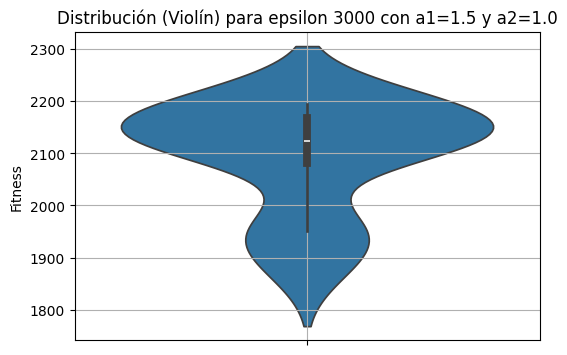

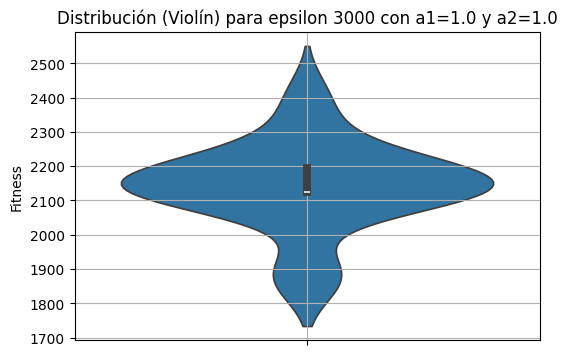

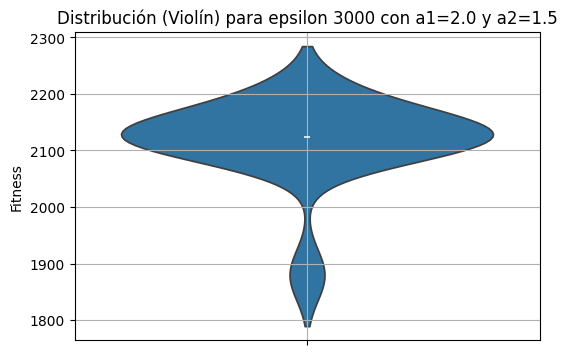

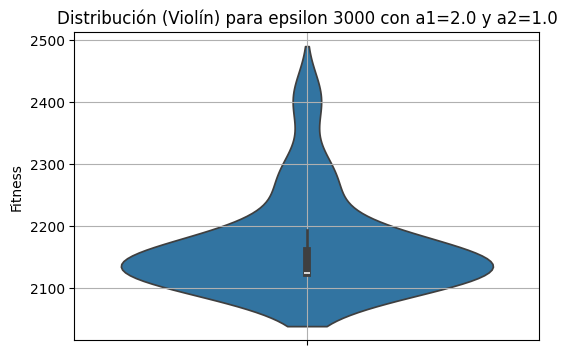

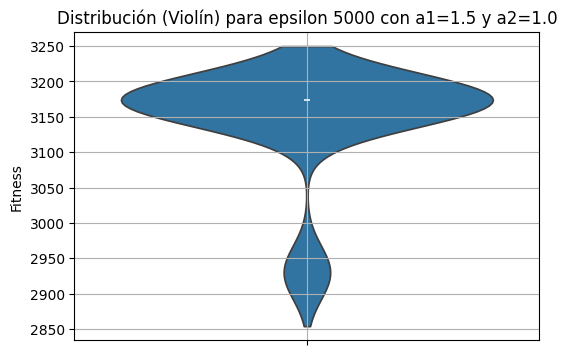

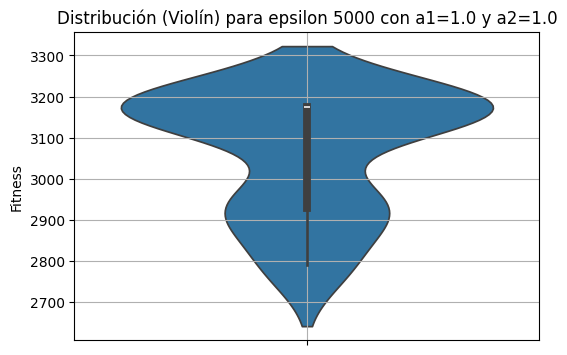

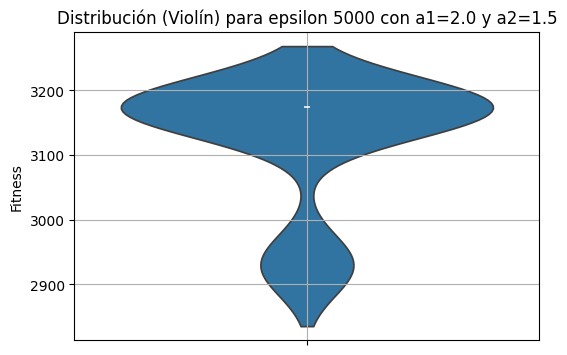

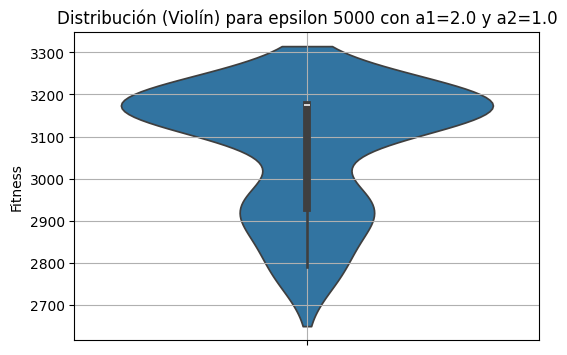

In [29]:
# Generacion de graficos de tipo violin
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from rich.console import Console
from rich.table import Table

# Crear una consola para la salida con rich
console = Console()

# Inicializar un diccionario para almacenar los datos
data_dict = {}

# Expresión regular para extraer los valores de a1 y a2 de los nombres de los archivos
pattern = re.compile(r'resultadosExp_(\d+\.?\d*)_a2_(\d+\.?\d*)\.csv')

# Función para recorrer los subdirectorios y procesar los archivos CSV
def procesar_archivos_en_directorio(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                match = pattern.match(file)
                if match:
                    a1, a2 = match.groups()
                    epsilon = int(subdir.split('_')[-1])
                    
                    # Convertir los valores a los tipos adecuados
                    a1 = float(a1)
                    a2 = float(a2)
                    
                    # Leer el archivo CSV
                    filepath = os.path.join(subdir, file)
                    df = pd.read_csv(filepath)
                    
                    # Inicializar un diccionario para los datos de este epsilon si no existe
                    if epsilon not in data_dict:
                        data_dict[epsilon] = {}
                    
                    # Inicializar un DataFrame para esta combinación de a1 y a2
                    key = f"{a1}-{a2}"
                    if key not in data_dict[epsilon]:
                        data_dict[epsilon][key] = pd.DataFrame()
                    
                    data_dict[epsilon][key] = pd.concat([data_dict[epsilon][key], df])

# Procesar los archivos en el directorio actual
procesar_archivos_en_directorio(os.getcwd())

# Generar gráficos de violín agrupados por epsilon
for epsilon, grupos in data_dict.items():
    for key, df in grupos.items():
        a1, a2 = key.split('-')
        a1, a2 = float(a1), float(a2)
        
        # Gráfico de violín
        plt.figure(figsize=(6, 4))
        sns.violinplot(data=df, y='fit')
        plt.title(f"Distribución (Violín) para epsilon {epsilon} con a1={a1} y a2={a2}")
        plt.ylabel("Fitness")
        plt.grid(True)
        plt.show()


### Generacion de grafico
#### Fronteras de Pareto

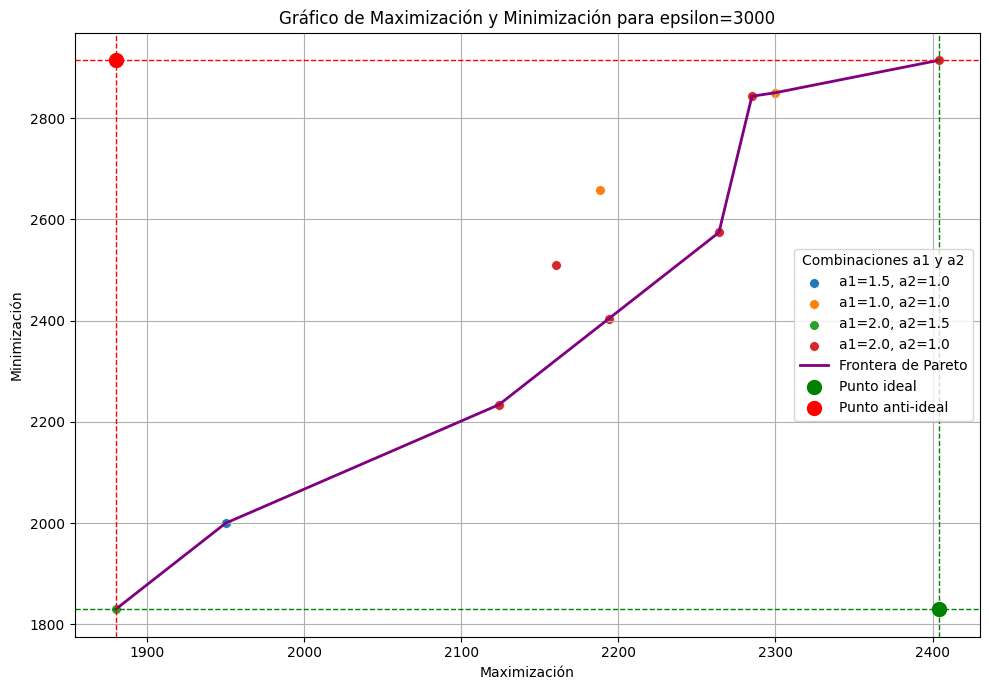

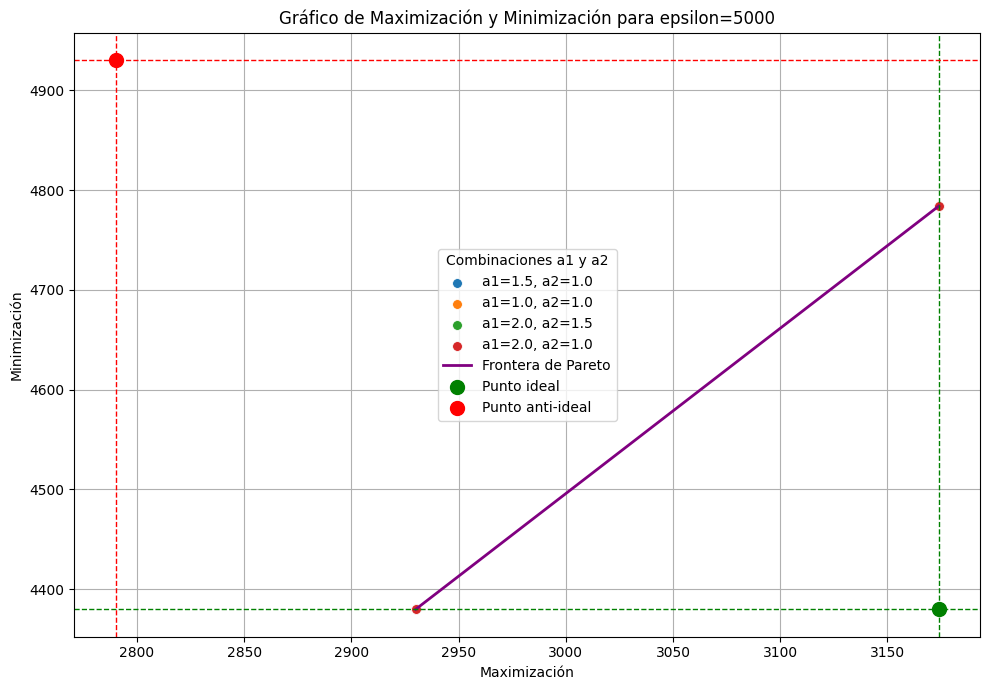

In [56]:
# Generacion de Frontears de Pareto
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializar un diccionario para almacenar los datos
data_dict = {}

# Expresión regular para extraer los valores de a1 y a2 de los nombres de los archivos
pattern = re.compile(r'resultadosExp_(\d+\.?\d*)_a2_(\d+\.?\d*)\.csv')

# Función para recorrer los subdirectorios y procesar los archivos CSV
def procesar_archivos_en_directorio(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                match = pattern.match(file)
                if match:
                    a1, a2 = match.groups()
                    epsilon = int(subdir.split('_')[-1])
                    
                    # Convertir los valores a los tipos adecuados
                    a1 = float(a1)
                    a2 = float(a2)
                    
                    # Leer el archivo CSV
                    filepath = os.path.join(subdir, file)
                    df = pd.read_csv(filepath)
                    
                    # Inicializar un diccionario para los datos de este epsilon si no existe
                    if epsilon not in data_dict:
                        data_dict[epsilon] = {}
                    
                    # Inicializar un DataFrame para esta combinación de a1 y a2
                    key = f"{a1}-{a2}"
                    if key not in data_dict[epsilon]:
                        data_dict[epsilon][key] = pd.DataFrame()
                    
                    # Concatenar los datos leídos
                    data_dict[epsilon][key] = pd.concat([data_dict[epsilon][key], df], ignore_index=True)

# Procesar los archivos en el directorio actual
procesar_archivos_en_directorio(os.getcwd())

# Función para obtener puntos ideal y anti-ideal
def get_ideal_points(df, objective1, objective2):
    ideal = {
        objective1: df[objective1].max(),
        objective2: df[objective2].min()
    }
    anti_ideal = {
        objective1: df[objective1].min(),
        objective2: df[objective2].max()
    }
    return ideal, anti_ideal

# Función para identificar la frontera de Pareto
def get_pareto_front(df, objective1, objective2):
    pareto = []
    df_sorted = df.sort_values(by=[objective2, objective1], ascending=[True, False])
    pareto.append(df_sorted.iloc[0].to_dict())
    for row in df_sorted.iloc[1:].itertuples(index=False):
        if getattr(row, objective1) > pareto[-1][objective1]:
            pareto.append(row._asdict())
    return pd.DataFrame(pareto)

# Generar gráficos agrupados por epsilon
for epsilon, grupos in data_dict.items():
    plt.figure(figsize=(10, 7))
    all_data = pd.DataFrame()
    
    for key, df in grupos.items():
        all_data = pd.concat([all_data, df], ignore_index=True)
        
        a1, a2 = key.split('-')
        a1, a2 = float(a1), float(a2)
        
        # Gráfico de dispersión con ejes invertidos
        sns.scatterplot(data=df, x='Maximizacion', y='Minimizacion', label=f'a1={a1}, a2={a2}', s=50)
    
    # Calcular puntos ideal y anti-ideal para todos los datos combinados
    ideal, anti_ideal = get_ideal_points(all_data, 'Maximizacion', 'Minimizacion')

    # Obtener y graficar la frontera de Pareto
    pareto_front = get_pareto_front(all_data, 'Maximizacion', 'Minimizacion')
    if not pareto_front.empty:
        plt.plot(pareto_front['Maximizacion'], pareto_front['Minimizacion'], color='purple', linestyle='-', linewidth=2, label='Frontera de Pareto')
    
    # Añadir puntos ideal y anti-ideal
    plt.scatter(ideal['Maximizacion'], ideal['Minimizacion'], color='green', s=100, label='Punto ideal', zorder=5)
    plt.scatter(anti_ideal['Maximizacion'], anti_ideal['Minimizacion'], color='red', s=100, label='Punto anti-ideal', zorder=5)
    
    # Añadir líneas punteadas
    plt.axvline(x=ideal['Maximizacion'], color='green', linestyle='--', linewidth=1)
    plt.axhline(y=ideal['Minimizacion'], color='green', linestyle='--', linewidth=1)
    plt.axvline(x=anti_ideal['Maximizacion'], color='red', linestyle='--', linewidth=1)
    plt.axhline(y=anti_ideal['Minimizacion'], color='red', linestyle='--', linewidth=1)
    
    plt.title(f'Gráfico de Maximización y Minimización para epsilon={epsilon}')
    plt.xlabel('Maximización')
    plt.ylabel('Minimización')
    plt.legend(title='Combinaciones a1 y a2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
